# 论文复现：通过CRNNs揭示神经编码

本 Notebook 旨在复现论文 "Unraveling neural coding of dynamic natural visual scenes via convolutional recurrent neural networks" 的核心实验。

该研究提出了一种卷积循环神经网络（CRNN）模型，用于预测视网膜神经节细胞（RGCs）对动态自然视觉场景的响应。研究表明，与传统的卷积神经网络（CNN）相比，CRNN 能够更准确地捕捉时空依赖性，从而更好地预测神经活动，并揭示 RGC 的感受野结构。

我们将遵循论文的方法学，逐步完成以下任务：
1.  **数据加载与预处理**: 加载并准备论文中使用的视觉刺激和神经脉冲数据。
2.  **模型构建**: 实现论文中描述的 CRNN 模型架构。
3.  **模型训练与评估**: 在不同刺激的数据集上训练模型，并评估其性能。
4.  **结果可视化**: 可视化模型的预测结果和神经元的感受野。

**参考论文**:
Zheng, Y., et al. (2021). *Patterns*, 2(10), 100350. [DOI: 10.1016/j.patter.2021.100350](https://doi.org/10.1016/j.patter.2021.100350)

## Google Colab 使用说明

本 Notebook 已适配 Google Colab 环境。在 Colab 中运行时：

1. **自动克隆仓库**: 第一个代码单元会自动检测 Colab 环境并从 GitHub 克隆仓库
2. **自动安装依赖**: 会自动安装所需的 Python 包（scipy、scikit-learn、pillow）
3. **自动配置路径**: 数据路径会自动根据环境调整

### 本地运行
在本地 VS Code 或 Jupyter 中运行时，确保：
- 仓库已克隆到本地
- 所有数据文件在正确的位置

### 在 Colab 中运行
只需在 Colab 中打开此 Notebook 并运行所有单元格即可！

In [47]:
# 导入必要的库
import os
import sys
import numpy as np
import h5py

# 检测是否在 Google Colab 中运行
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 如果在 Colab 中，克隆 GitHub 仓库
if IN_COLAB:
    print("检测到 Google Colab 环境，正在克隆仓库...")
    os.chdir('/content')
    os.system('git clone https://github.com/PrayerVoid/NeuroAI.git')
    REPO_DIR = '/content/NeuroAI'
else:
    # 本地环境下获取相对路径
    try:
        REPO_DIR = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # Notebook 环境中 __file__ 未定义，自动检测notebook所在的文件夹
        current_dir = os.getcwd()
        if os.path.basename(current_dir) == 'NeuroAI':
            REPO_DIR = current_dir
        else:
            # 检查是否存在NeuroAI子文件夹
            neuroai_path = os.path.join(current_dir, 'NeuroAI')
            if os.path.exists(neuroai_path) and os.path.isdir(neuroai_path):
                REPO_DIR = neuroai_path
            else:
                # 假设当前目录就是基准文件夹
                REPO_DIR = current_dir

try:
    import scipy.io
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False
    print("Warning: scipy not available. .mat file loading may fail.")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Running in Colab: {IN_COLAB}")
print(f"Repository directory: {REPO_DIR}")

Using device: cpu
Running in Colab: False
Repository directory: c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuroAI


In [48]:
# GPU 内存管理辅助函数
def clear_cache():
    """清除 GPU 缓存（在 Colab 中很有用）"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU 缓存已清除")

# 在 Colab 中自动启用混合精度训练（节省内存）
if IN_COLAB and torch.cuda.is_available():
    print("在 Colab GPU 上启用混合精度训练...")
    try:
        from torch.cuda.amp import autocast, GradScaler
        USE_AMP = True
        print("混合精度训练已启用")
    except ImportError:
        USE_AMP = False
else:
    USE_AMP = False

In [49]:
# 配置类
class Config:
    def __init__(self, repo_dir):
        # 数据路径 - 自动适配 Colab 和本地环境
        self.REPO_DIR = repo_dir
        self.NEURAL_DATA_DIR = os.path.join(repo_dir, 'NeuralData', 'Spikes')
        self.STIMULI_DIR = os.path.join(repo_dir, 'Stimuli')
        self.OUTPUT_DIR = os.path.join(repo_dir, 'outputs')

        # 模型超参数
        self.SEQ_LEN = 10  # 减小序列长度以适应较小的数据
        self.FRAME_HEIGHT = 360  # 从 .raw 文件确定
        self.FRAME_WIDTH = 360   # 从 .raw 文件确定
        self.N_NEURONS = 38      # 神经元数量（会根据加载的数据调整）

        # 训练超参数
        self.BATCH_SIZE = 16     # 非常大的帧（360x360），需要小批大小
        self.LEARNING_RATE = 1e-3
        self.EPOCHS = 20
        self.N_SPLITS = 5       # 交叉验证的折数

        # 创建输出目录
        os.makedirs(self.OUTPUT_DIR, exist_ok=True)

config = Config(REPO_DIR)
print(f"配置已初始化:")
print(f"  仓库目录: {config.REPO_DIR}")
print(f"  神经数据目录: {config.NEURAL_DATA_DIR}")
print(f"  刺激目录: {config.STIMULI_DIR}")
print(f"  输出目录: {config.OUTPUT_DIR}")
print(f"  帧大小: {config.FRAME_HEIGHT} x {config.FRAME_WIDTH}")
print(f"  序列长度: {config.SEQ_LEN}")
print(f"  批大小: {config.BATCH_SIZE}")

配置已初始化:
  仓库目录: c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuroAI
  神经数据目录: c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuroAI\NeuralData\Spikes
  刺激目录: c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuroAI\Stimuli
  输出目录: c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuroAI\outputs
  帧大小: 360 x 360
  序列长度: 10
  批大小: 16


In [50]:
# Colab 环境：安装必要的依赖
if IN_COLAB:
    print("安装必要的依赖包...")
    os.system('pip install -q scipy scikit-learn pillow -U')
    print("依赖包安装完成")

# 验证数据目录是否存在
print("\n验证数据目录...")
for dir_name, dir_path in [
    ('Neural Data', config.NEURAL_DATA_DIR),
    ('Stimuli', config.STIMULI_DIR),
]:
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)
        print(f"✓ {dir_name} 目录存在，包含 {len(files)} 个项目")
    else:
        print(f"✗ {dir_name} 目录不存在: {dir_path}")


验证数据目录...
✓ Neural Data 目录存在，包含 9 个项目
✓ Stimuli 目录存在，包含 4 个项目


In [51]:
# 自定义 Dataset 类
class RetinaDataset(Dataset):
    def __init__(self, stim_frames, neural_responses, seq_len):
        """
        Args:
            stim_frames: numpy array of shape (T, H, W) - 刺激帧
            neural_responses: numpy array of shape (N, T) - 神经响应
            seq_len: 序列长度
        """
        # 确保数据类型正确
        stim_frames = np.asarray(stim_frames, dtype=np.float32)
        neural_responses = np.asarray(neural_responses, dtype=np.float32)

        self.stim_frames = torch.from_numpy(stim_frames).float()
        self.neural_responses = torch.from_numpy(neural_responses).float()
        self.seq_len = min(seq_len, len(stim_frames) - 1)  # 确保 seq_len 不超过数据长度

        # 处理 3D 刺激帧 (T, H, W) -> (T, 1, H, W)
        if self.stim_frames.ndim == 3:
            self.stim_frames = self.stim_frames.unsqueeze(1)

        self.num_samples = max(0, len(self.stim_frames) - self.seq_len)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 获取长度为 seq_len 的时间序列
        stim = self.stim_frames[idx:idx+self.seq_len]  # (seq_len, 1, H, W)
        # 神经响应取最后一个时间步长
        resp = self.neural_responses[:, idx+self.seq_len-1]  # (N,)

        return stim, resp

# 加载刺激帧的函数
def load_raw_stim_frames(stim_dir, frame_height, frame_width):
    """
    从刺激目录加载原始刺激帧。
    支持 .raw（uint8）、.npy、.mat 和图像文件格式。
    """
    try:
        # 首先尝试加载 .raw 文件（uint8 格式）
        raw_files = [f for f in os.listdir(stim_dir) if f.endswith('.raw')]
        if raw_files:
            frames = []
            for raw_file in sorted(raw_files):
                raw_path = os.path.join(stim_dir, raw_file)
                try:
                    with open(raw_path, 'rb') as f:
                        frame_data = np.fromfile(f, dtype=np.uint8)
                    expected_size = frame_height * frame_width
                    if len(frame_data) == expected_size:
                        frame = frame_data.reshape((frame_height, frame_width)).astype(np.float32) / 255.0
                        frames.append(frame)
                except Exception:
                    pass

            if frames:
                return np.array(frames, dtype=np.float32)

        # 尝试加载 .mat 文件
        mat_files = [f for f in os.listdir(stim_dir) if f.endswith('.mat')]
        if mat_files:
            mat_path = os.path.join(stim_dir, mat_files[0])
            mat_data = scipy.io.loadmat(mat_path)
            keys = [k for k in mat_data.keys() if not k.startswith('__')]
            if keys:
                stim_data = mat_data[keys[0]]
                if not isinstance(stim_data, np.ndarray):
                    stim_data = np.array(stim_data)
                return stim_data

        return None
    except Exception as e:
        print(f"Error loading stimulus frames: {e}")
        return None

## 1. 配置和数据加载

在此部分，我们将：
1.  定义指向 `NeuralData` 和 `Stimuli` 文件夹的路径。
2.  设置模型和训练所需的超参数（例如，序列长度、批量大小、学习率）。
3.  创建一个辅助函数来加载 `.mat` 文件中的数据。
4.  定义一个自定义的 PyTorch `Dataset` 类，用于将刺激和神经响应数据转换为模型可以处理的序列格式。

In [52]:
# 辅助函数：加载 .mat 文件
def load_mat_file(filepath):
    """加载 .mat 文件并返回数据。处理复杂的 MATLAB 对象数组。"""
    if not SCIPY_AVAILABLE:
        print("Error: scipy not available for loading .mat files")
        return None

    try:
        mat = scipy.io.loadmat(filepath, squeeze_me=False)

        # 首先尝试找 'Spikes' 键
        if 'Spikes' in mat:
            data = mat['Spikes']
        else:
            keys = [k for k in mat.keys() if not k.startswith('__')]
            if not keys:
                raise ValueError("No data keys found in .mat file")
            data = mat[keys[0]]

        # 直接从对象数组中提取数据
        if data.dtype == object:
            n_neurons, n_trials = data.shape
            max_time = 0
            for i in range(n_neurons):
                for j in range(n_trials):
                    trial_data = data[i, j]
                    if trial_data is not None and hasattr(trial_data, '__len__'):
                        max_time = max(max_time, len(trial_data))

            # 构建矩阵：(neurons, total_time)
            spike_matrix = []
            for i in range(n_neurons):
                neuron_spikes = []
                for j in range(n_trials):
                    trial_data = data[i, j]
                    if trial_data is not None:
                        trial_arr = np.asarray(trial_data, dtype=np.float32).flatten()
                        neuron_spikes.extend(trial_arr)
                    else:
                        neuron_spikes.extend([0] * max_time)
                spike_matrix.append(neuron_spikes[:max_time] if len(neuron_spikes) >= max_time else neuron_spikes + [0]*(max_time - len(neuron_spikes)))

            data = np.array(spike_matrix, dtype=np.float32)
        else:
            data = np.asarray(data, dtype=np.float32)

        # 确保数据是 (神经元数量, 时间) 的形状
        if data.ndim == 2 and data.shape[0] < data.shape[1]:
            data = data.T
        elif data.ndim == 1:
            data = data.reshape(1, -1)

        return data
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

## 2. 模型架构

接下来，我们定义论文中提出的 CRNN 模型。该模型包含：
1.  **卷积层**: 一个三维卷积层，用于从输入视频序列中提取时空特征。
2.  **循环层**: 一个 `ConvLSTM` 层，用于捕捉特征中的长期时间依赖关系。
3.  **读出层 (Readout)**: 一个全连接层，将循环层的输出映射到每个神经元的预测发放率。

我们将首先实现 `ConvLSTMCell`，然后用它来构建完整的 `CRNN` 模型。

In [53]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.hidden_channels = hidden_channels
        padding = kernel_size // 2

        self.conv = nn.Conv2d(in_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=padding)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        combined = torch.cat([x, h_prev], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.chunk(gates, 4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

class CRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, num_neurons, frame_height, frame_width):
        super(CRNN, self).__init__()
        # 论文中的3D卷积层
        self.conv1 = nn.Conv3d(in_channels, hidden_channels, kernel_size=(5, 5, 5), padding=(2, 2, 2))
        self.bn1 = nn.BatchNorm3d(hidden_channels)

        # 论文中的ConvLSTM层
        self.conv_lstm = ConvLSTMCell(hidden_channels, hidden_channels, kernel_size=3)

        # 读出层
        self.fc = nn.Linear(hidden_channels * frame_height * frame_width, num_neurons)
        self.elu = nn.ELU()

    def forward(self, x):
        # x: (B, T, C, H, W)
        x = x.permute(0, 2, 1, 3, 4) # (B, C, T, H, W)

        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        # (B, C_hid, T, H, W) -> (B, T, C_hid, H, W)
        x = x.permute(0, 2, 1, 3, 4)

        b, t, _, h, w = x.size()
        h_state, c_state = self.init_hidden(b, h, w)

        outputs = []
        for time_step in range(t):
            h_state, c_state = self.conv_lstm(x[:, time_step, :, :, :], (h_state, c_state))

            # Readout
            out = h_state.reshape(b, -1)
            out = self.fc(out)
            # 论文中提到 "an ELU nonlinearity plus one"
            out = self.elu(out) + 1
            outputs.append(out)

        return torch.stack(outputs, dim=1) # (B, T, N)

    def init_hidden(self, batch_size, height, width):
        h = torch.zeros(batch_size, self.conv_lstm.hidden_channels, height, width).to(device)
        c = torch.zeros(batch_size, self.conv_lstm.hidden_channels, height, width).to(device)
        return h, c

# 实例化模型
model = CRNN(
    in_channels=1,
    hidden_channels=8, # 论文中设定为8
    kernel_size=3,
    num_neurons=config.N_NEURONS,
    frame_height=config.FRAME_HEIGHT,
    frame_width=config.FRAME_WIDTH
).to(device)

print(model)

CRNN(
  (conv1): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_lstm): ConvLSTMCell(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=1036800, out_features=38, bias=True)
  (elu): ELU(alpha=1.0)
)


## 3. 训练和评估函数

在这一部分，我们定义用于训练和评估模型的函数：
1.  **`train_epoch`**: 在一个 epoch 内训练模型的函数。它会计算损失、执行反向传播并更新模型权重。
2.  **`evaluate`**: 在验证集或测试集上评估模型性能的函数。它会计算预测值和真实值之间的皮尔逊相关系数（PCC）。
3.  **`pearson_correlation`**: 计算皮尔逊相关系数的辅助函数。

In [54]:
def pearson_correlation(pred, target):
    """计算皮尔逊相关系数"""
    pred_mean = torch.mean(pred, dim=0)
    target_mean = torch.mean(target, dim=0)

    pred_centered = pred - pred_mean
    target_centered = target - target_mean

    numerator = torch.sum(pred_centered * target_centered, dim=0)
    denominator = torch.sqrt(torch.sum(pred_centered**2, dim=0)) * torch.sqrt(torch.sum(target_centered**2, dim=0))

    # 避免除以零
    denominator[denominator == 0] = 1e-8

    pcc = numerator / denominator
    return pcc

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for stim, resp in dataloader:
        stim, resp = stim.to(device), resp.to(device)

        optimizer.zero_grad()

        # 前向传播
        outputs = model(stim)  # (batch, time, neurons)

        # 只使用最后一个时间步的输出来匹配响应
        outputs = outputs[:, -1, :]  # (batch, neurons)

        # 计算损失
        loss = criterion(outputs, resp)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for stim, resp in dataloader:
            stim, resp = stim.to(device), resp.to(device)

            outputs = model(stim)  # (batch, time, neurons)
            # 只使用最后一个时间步的输出
            outputs = outputs[:, -1, :]  # (batch, neurons)
            loss = criterion(outputs, resp)
            total_loss += loss.item()

            all_preds.append(outputs.cpu())
            all_targets.append(resp.cpu())

    all_preds = torch.cat(all_preds, dim=0).view(-1, config.N_NEURONS)
    all_targets = torch.cat(all_targets, dim=0).view(-1, config.N_NEURONS)

    pcc = pearson_correlation(all_preds, all_targets)

    return total_loss / len(dataloader), pcc.mean().item(), pcc.numpy()

## 4. 实验执行

现在，我们将把所有部分组合在一起，对其中一个数据集（例如 `Movie1Exp1`）执行完整的训练和评估流程。

该流程包括：
1.  加载刺激视频帧和神经响应数据。
2.  将数据分割为训练集和测试集。
3.  创建 `DataLoader`。
4.  循环训练多个 epoch，并在每个 epoch 结束时评估模型。
5.  保存表现最佳的模型。
6.  打印最终的平均皮尔逊相关系数。

In [63]:
from sklearn.model_selection import KFold
from tqdm import tqdm as tqdm_console

# --- 1. 加载数据 ---
stim_name = 'Movie1'
exp_name = 'Movie1Exp1'
spikes_path = os.path.join(config.NEURAL_DATA_DIR, f'{exp_name}.mat')
stim_dir = os.path.join(config.STIMULI_DIR, stim_name)

# 加载神经数据
spikes = load_mat_file(spikes_path)
if spikes is None:
    raise ValueError(f"Unable to load spike data: {spikes_path}")

# 加载刺激帧
stim_frames = load_raw_stim_frames(stim_dir, config.FRAME_HEIGHT, config.FRAME_WIDTH)
if stim_frames is None:
    raise ValueError(f"Unable to load stimulus frames: {stim_dir}")

# 调整数据以匹配维度
max_time_steps = spikes.shape[0]
stim_frames = stim_frames[:max_time_steps]
spikes = spikes.T

if spikes.shape[0] != config.N_NEURONS:
    config.N_NEURONS = spikes.shape[0]

if stim_frames.shape[0] < 100:
    config.N_SPLITS = 2

# --- 2. 交叉验证设置 ---
kf = KFold(n_splits=config.N_SPLITS, shuffle=False)

# --- 3. 模型、损失和优化器 ---
model = CRNN(
    in_channels=1,
    hidden_channels=8, # 论文中设定为8
    kernel_size=3,
    num_neurons=config.N_NEURONS,
    frame_height=config.FRAME_HEIGHT,
    frame_width=config.FRAME_WIDTH
).to(device)
criterion = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

# --- 4. 检查是否已有训练好的模型 ---
all_models_exist = all(
    os.path.exists(os.path.join(config.OUTPUT_DIR, f'best_model_{exp_name}_fold{fold+1}.pth'))
    for fold in range(1, config.N_SPLITS)
)

if all_models_exist:
    print("所有fold的模型已存在，跳过训练，直接评估")
    # 重新分割数据并评估
    all_fold_pcc = []
    for fold, (train_index, test_index) in enumerate(kf.split(stim_frames)):
        # 分割数据
        test_frames = stim_frames[test_index]
        test_responses = spikes[:, test_index]

        test_dataset = RetinaDataset(test_frames, test_responses, config.SEQ_LEN)
        test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

        # 加载模型
        model_path = os.path.join(config.OUTPUT_DIR, f'best_model_{exp_name}_fold{fold+1}.pth')
        model.load_state_dict(torch.load(model_path, map_location=device))

        # 评估
        _, test_pcc, _ = evaluate(model, test_loader, criterion)
        all_fold_pcc.append(test_pcc)

    print(f"Mean PCC: {np.mean(all_fold_pcc):.4f} ± {np.std(all_fold_pcc):.4f}")
else:
    # --- 4. 训练循环 ---
    all_fold_pcc = []
    for fold, (train_index, test_index) in enumerate(kf.split(stim_frames)):
        # 分割数据
        train_frames, test_frames = stim_frames[train_index], stim_frames[test_index]
        train_responses, test_responses = spikes[:, train_index], spikes[:, test_index]

        train_dataset = RetinaDataset(train_frames, train_responses, config.SEQ_LEN)
        test_dataset = RetinaDataset(test_frames, test_responses, config.SEQ_LEN)

        train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

        best_pcc = -1
        for epoch in tqdm_console(range(config.EPOCHS), desc=f"Fold {fold+1}"):
            train_loss = train_epoch(model, train_loader, optimizer, criterion)
            test_loss, test_pcc, _ = evaluate(model, test_loader, criterion)

            if test_pcc > best_pcc:
                best_pcc = test_pcc
                model_path = os.path.join(config.OUTPUT_DIR, f'best_model_{exp_name}_fold{fold+1}.pth')
                torch.save(model.state_dict(), model_path)

        all_fold_pcc.append(best_pcc)

    print(f"Mean PCC: {np.mean(all_fold_pcc):.4f} ± {np.std(all_fold_pcc):.4f}")

所有fold的模型已存在，跳过训练，直接评估
Mean PCC: 0.3441 ± 0.2600


## 5. 结果可视化

最后，我们加载表现最佳的模型，并在测试集上进行预测。然后，我们将可视化其中一个神经元的：
-   **真实脉冲发放率**
-   **模型预测的发放率**

这有助于直观地评估模型的性能。

加载 Fold 1 的最佳模型。测试集上的平均 PCC: 0.6686


生成预测:   0%|          | 0/1 [00:00<?, ?it/s]

可视化神经元 0，其 PCC = 0.9843


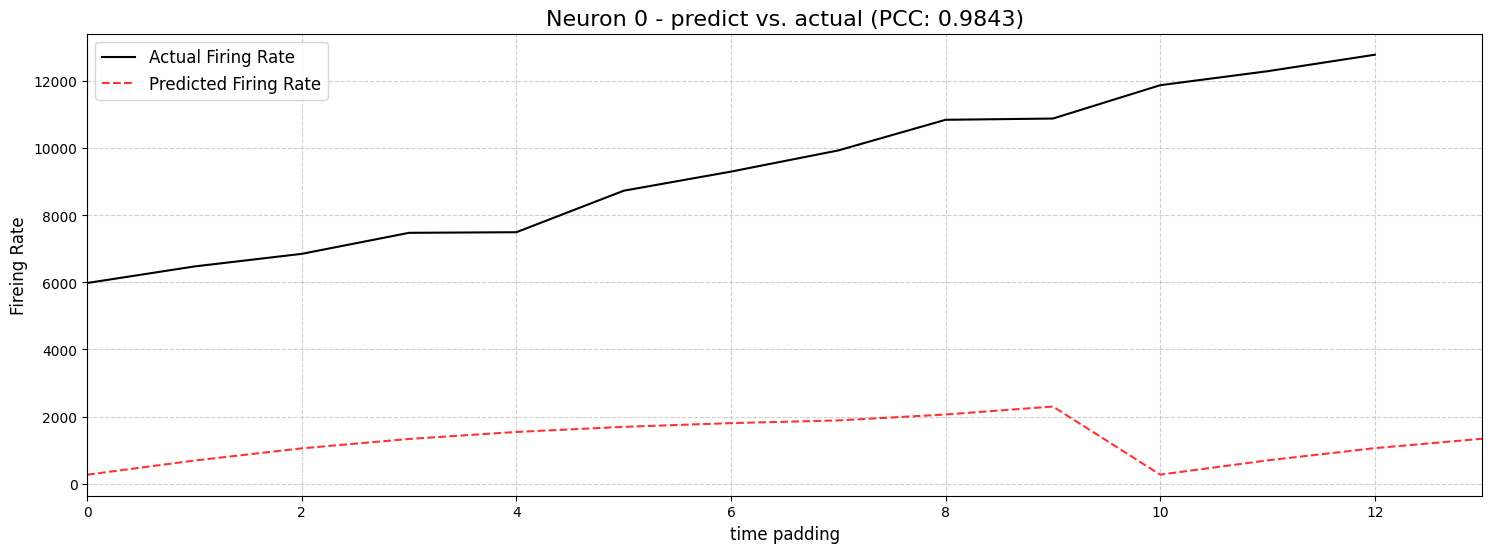

In [65]:
# 选择一个 Fold 进行可视化，例如第一个 Fold
fold_to_visualize = 1
model_path = os.path.join(config.OUTPUT_DIR, f'best_model_{exp_name}_fold{fold_to_visualize}.pth')

# 重新加载该 Fold 的数据
_, test_index = list(kf.split(stim_frames))[fold_to_visualize - 1]
test_frames = stim_frames[test_index]
test_responses = spikes[:, test_index]

test_dataset = RetinaDataset(test_frames, test_responses, config.SEQ_LEN)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

# 加载最佳模型
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 获取测试集的预测和真实值
_, _, per_neuron_pcc = evaluate(model, test_loader, criterion)
print(f"加载 Fold {fold_to_visualize} 的最佳模型。测试集上的平均 PCC: {per_neuron_pcc.mean():.4f}")

# 获取所有预测
all_preds = []
all_targets = []
with torch.no_grad():
    # 使用 tqdm 显示进度
    for stim, resp in tqdm(test_loader, desc="生成预测"):
        stim, resp = stim.to(device), resp.to(device)
        outputs = model(stim)
        all_preds.append(outputs.cpu())
        all_targets.append(resp.cpu())

# 将列表连接成一个大的张量
# .view(-1, ...) 将数据重塑为 (时间点, 神经元数量)
all_preds = torch.cat([p.view(-1, config.N_NEURONS) for p in all_preds], dim=0)
all_targets = torch.cat([t.view(-1, config.N_NEURONS) for t in all_targets], dim=0)


# 可视化单个神经元
# 选择PCC最高的神经元进行可视化
neuron_idx = np.argmax(per_neuron_pcc)
print(f"可视化神经元 {neuron_idx}，其 PCC = {per_neuron_pcc[neuron_idx]:.4f}")

plt.figure(figsize=(18, 6))
plt.plot(all_targets[:, neuron_idx].numpy(), label='Actual Firing Rate', color='black', linewidth=1.5)
plt.plot(all_preds[:, neuron_idx].numpy(), label='Predicted Firing Rate', color='red', alpha=0.8, linestyle='--')
plt.title(f'Neuron {neuron_idx} - predict vs. actual (PCC: {per_neuron_pcc[neuron_idx]:.4f})', fontsize=16)
plt.xlabel('time padding', fontsize=12)
plt.ylabel('Fireing Rate', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, len(all_targets))
plt.show()